# Machines Received:
### Automate purchase order data visualizations

### Cost Cleaner:
#### Establishing a cost basis upon which to reference our work.

This information luckily exists, but is in a crowded format and needs a little preening to be of best use.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

This function uses 're', or RegEx (Regular Expression)

Though 're' needs to be imported, it is included in The Python Standard Library and does not need to be specifically installed using pip.

The purpose of this function is to format our machine models in a way which excludes their designation as being "in a receiving status" within the workplace databases. These designations are assigned as a means of tracking each unique machine and therefore have no use to us in this capacity.

In [2]:
# Function to remove "REC-" leading model names
def rec_remover():
    for elem in models_scan:
        model = re.sub(r"REC-", "", elem)
        count = data.SKU.value_counts()[elem]
        models_list.append(model)
        counts_list.append(count)
        print(model, count)

Here we reference what state the existing CSV values are in, and import the CSV into a variable named "cost_csv_raw".

In [3]:
# Check data types of columns
print(pd.read_csv('assets/DT_export(baseline_model_cost).csv').dtypes)

# Import csv (specific columns)
cost_csv_raw = pd.read_csv('assets/DT_export(baseline_model_cost).csv', usecols=['Model SKU', 'Current Base Line Cost'])
print(cost_csv_raw)

Unnamed: 0                                 float64
Model SKU                                   object
SKU Class                                   object
Recent Stock Avergae Cost                  float64
Recent Stock Quantity Eligible / Active     object
All Stock Avergae Cost                     float64
All Stock Quantity Eligible / Active        object
Reminder Date                               object
Reminder Notes                             float64
Last Updated                                object
Updated By                                  object
Current Base Line Cost                     float64
Base Line Cost                             float64
Unnamed: 13                                float64
dtype: object
             Model SKU  Current Base Line Cost
0              -M-I5DC                     0.0
1              -U-8200                     0.0
2              -U-I5QC                     0.0
3              -U-I7QC                     0.0
4    10G9000NUS-M-PENT               

Upon looking over our initial data, two high-end outliers are removed and the dataframe is sorted high to low. Machines valued below a dollar are also removed as these are older model SKUs that have been marked for scrap.

In [4]:
# Find highest price
# Later Addition: we now know the two highest are outliers. Adjusting trim range below to accomodate.
print(cost_csv_raw.max())

# Trim to range
cost_adjusted_range = cost_csv_raw[cost_csv_raw['Current Base Line Cost'].between(1, 301)]
print(cost_adjusted_range)

# Sort by price high to low
cost_sorted = cost_adjusted_range.sort_values(by='Current Base Line Cost', ascending=False)

Model SKU                 Z400-T-XEQC
Current Base Line Cost          509.0
dtype: object
          Model SKU  Current Base Line Cost
9       3010-D-I5QC                    45.0
11      3010-T-I5QC                    45.0
12      3020-M-I5QC                    30.0
13      3020-T-I5QC                    50.0
16     3020M-M-I5QC                    30.0
..              ...                     ...
379  SLICEG1-M-I5QC                    56.0
383   T510-U-EDENDC                    50.0
397    T610-U-GT56N                    50.0
399     T820-U-I5QC                    65.0
414     Z240-D-I5QC                    55.0

[185 rows x 2 columns]


*This section was added much later into the program's progress, as the issue wasn't apparent until that later time.*

**The processors in this list thus far are not as immediately compatable with future incoming data as I initially assumed. We need them to match perfectly in order to merge them in with our future dataframe.**

Some background information is helpful in understanding: 
- Machines are received at face value; 
  - The model listed on the faceplate, as well as the VERY BASIC processor info from the sticker on the case.
  - Examples: i3, i5, i7, Celeron, Core 2 Duo
- The model cost information (in the imported CSV file) has more detailed information for each model;
  - This information is gathered after receiving takes place.
  - It is pulled directly from the motherboard to include some specific processor information.
  - Examples: i3 Dual Core (I3DC), i5 Quad Core(I5QC), i7 Hexa/Six Core (I7HC/I7SC)
  
The mode of removal we used has inadvertently affected our AMD and C2D models. These specifically are repaired with additional code, and our cleaned reference information is saved as a separate csv.

In [5]:
# Much later addition: After working on main body of project, more cleaning needed
# Remove intel processor denominations after I3/I5/I7 (i.e. I3DC, I5QC, I7HC)
# These are not recorded upon receiving causing merge mismatch between dataframes
cost_sorted['Model SKU'] = cost_sorted['Model SKU'].str.strip('QCHSD')

# Now to repair the AMD and Core 2 Duo processors stripped as collateral damage
# Thouch these processors are rare we can still keep this data in working condition to potentially match receiving scans
cost_sorted['Model SKU'] = cost_sorted['Model SKU'].str.replace('AM', 'AMD')
cost_sorted['Model SKU'] = cost_sorted['Model SKU'].str.replace('C2', 'C2D')

# Save to new csv for inspection
cost_sorted.to_csv('assets/cost_clean.csv')

### Machines Received:
#### Making sense of our Purchase Order data.

After physically receiving machines at my day job, the data is recorded by default as "DT_Export.csv" via a tool on the website of my workplace. We want this to be reproducable for any batch of machines received, so our method of manipulation works mainly with the columns themselves instead of the more specific information within. 

We import our CSV with receiving data.

**This file name can be changed to view other datasets from the "assets" folder.**
- I have included nine separate "DT_Export.csv" files named after their PO number.
- Examples: "DT_Export(10733).csv", "DT_Export(10743).csv", "DT_Export(10749).csv"

Our data is then cleaned to discern each unique model type received.

In [6]:
# import and save the SERIAL, SKU columns from csv
data = pd.read_csv('assets/DT_export.csv', usecols=['SERIAL', 'SKU'])

# create a list of the unique models in receiving format
models_scan = []
for i in data.SKU:
    if i not in models_scan:
        models_scan.append(i)

We call the "rec_remover" function to better format our data.
- Formatted model names are added to "models_list"
- Total counts of each model are tabulated in "counts_list"

In [7]:
# iterate through models list removing receiving format
# and add total count
counts_list = []
models_list = []

# Call function to remove "REC-" leading model names
# Prints machine quantities to the terminal to be copied/pasted for a follow-up email to the boss
rec_remover()

M710Q-M-I5 20
M720Q-M-I5 10
M73-M-I5 13
M700-M-I5 43
3070-M-I7 1
5050-M-I5 1


Information from our "rec_remover" function is added into a dataframe for our first visualization (declared as "df")

In [8]:
# Pandas datafram from the counts/models lists
df = pd.DataFrame(columns=['MODELS', 'COUNT'])
df['MODELS'] = models_list
df['COUNT'] = counts_list

Our cleaned cost data from the first section of the program is now reintroduced as the variable "cost".

The column "Current Base Line Cost" is renamed to "COST" for uniformity, syntax, and ease of use.

In [9]:
# Bring in cost data
cost = pd.read_csv('assets/cost_clean.csv', usecols=['Model SKU', 'Current Base Line Cost'])

# Rename long-winded column name which has lowercase letters to better fit
cost.rename(columns = {'Model SKU' : 'MODELS', 'Current Base Line Cost' : 'COST'}, inplace=True)
print(cost)

          MODELS   COST
0      M70Q-M-I5  300.0
1      M70Q-M-I5  300.0
2      7060-M-I7  240.0
3      7060-M-I7  240.0
4     7060-M-I76  240.0
..           ...    ...
180  M600-M-PENT   15.0
181     M600-M-P   15.0
182   M600-M-CEL   15.0
183   M58P-U-C2D   15.0
184    960-T-C2D   14.0

[185 rows x 2 columns]


Any information in the "cost" dataframe that has a value corresponding with our received machines dataframe "df" is then merged in to form a new cost column.

In [10]:
#df.join(cost)
test_merge = pd.merge(df, cost)
print(test_merge)

       MODELS  COUNT   COST
0  M710Q-M-I5     20   65.0
1  M720Q-M-I5     10  192.0
2  M720Q-M-I5     10  160.0
3  M720Q-M-I5     10  160.0
4    M73-M-I5     13   25.0
5    M73-M-I5     13   25.0
6   M700-M-I5     43   55.0
7   5050-M-I5      1  100.0


Here we group our rows by our model name for a uniform output.

Multiple rows from the "cost" dataframe will correspond with our machine models. This is due to separate costs from our more detailed processor information.
- Many machine models are originally produced with multiple configurations of varying processors.
- For example, and i3 Quad Core will have a higher monetary value than an i3 Dual Core, but we previously removed this specification from our initial cost dataframe.
- This leaves multiple merged values with different costs.

To circumvent this eventuality, our cleaned costs will now be averaged in order to determine the mean cost. The values are then converted from floats to whole integers for a cleaner look.

In [11]:
# Group machines by AVERAGE price of model if multiple costs exist
avg_merge = test_merge.groupby(['MODELS'], as_index=False).mean()
#avg_merge = test_merge.groupby(['MODELS', 'COUNT']).agg([np.average])
# Now change float to int

# Making these columns whole numbers
avg_merge.COST = avg_merge.COST.astype(int)
avg_merge.COUNT = avg_merge.COUNT.astype(int)
print(avg_merge)

       MODELS  COUNT  COST
0   5050-M-I5      1   100
1   M700-M-I5     43    55
2  M710Q-M-I5     20    65
3  M720Q-M-I5     10   170
4    M73-M-I5     13    25


This particular purchase order presented us with a unique challenge/opportunity.

This was our company's first time receiving a Dell 3070 i7 in a mini form factor. Therefore this machine has no prior cost basis to draw upon. This (albeit unique) occurance has the potential to skew future visualizations.
- We will account for this with a simple if/else statement.
  - If NaN appears in any of the rows of our newly created cost column, we have a new cost that does not exist in our "cost" dataframe.
  - If not, then business as usual.
- It also blesses us with the opportunity for *just a smidgen* of ASCII art.
- Finding machines with no cost basis is the exception rather than the rule.
  - The business typically purchases machines with which they have existing SKUs.
  - This streamlines sales listings on many separate e-commerce marketplaces.
  
**Abrasive asterisks will alert us to machines with an unaccounted cost basis, whereas soothing tildes will reassure us that all costs have been reconciled.**

In [12]:
# 3070 mini i7 model doesn't have a base cost yet. 
# It doesn't meet merge criteria and will be discarded when dataframes merge
# Need to account for this with notification
no_price = pd.merge(df, cost, how='left', indicator=False)

# Check for any machines with a NaN value in no_price dataframe
if no_price.COST.isnull().values.any():
    print("****************************************")
    print("*  Machines with no cost basis (NaN):  *")
    print("****************************************")
    print(no_price[no_price['COST'].isna()])
else :
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("~  All machines received have existing cost basis.  ~")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

****************************************
*  Machines with no cost basis (NaN):  *
****************************************
      MODELS  COUNT  COST
7  3070-M-I7      1   NaN


Here we begin to create a new dataframe ("cost_vis") with additional columns for our second visualization.

*At this point I felt that my grasp on lambdas was insufficient, yet they seemed to be the simples solution to creating the columns that we need. I compensated by taking a trip to youtube which was rewarding as evidenced in our code.*

We want to determine the total cost for each machine type purchased, so we multiply the total number by their averaged cost. This provides us with an estimated total purchase order cost ("total_cost").

After this we create another column to serve as a percentage value of the total purchase order cost.

Finally we sum the total percentages just to verify that they account for 100% of the purchase order price.

In [13]:
# New cost of PO df to make a visualization with lambda fun
cost_vis = avg_merge
cost_vis['TOTAL'] = cost_vis.apply(lambda x: x['COUNT'] * x['COST'], axis=1)
print(cost_vis)
total_cost = str(cost_vis['TOTAL'].sum())
print("Estimated total PO cost: $" + total_cost)
# Make a percentage column for cost_vis df. Each item in total column / total of whole column * 100 to play nice with charting
cost_vis['TOTALPCT'] = cost_vis.apply(lambda x: (x['TOTAL'] / cost_vis['TOTAL'].sum()) * 100, axis=1)
print(cost_vis)
# Making sure these percentages add up to 100
print(cost_vis['TOTALPCT'].sum())

       MODELS  COUNT  COST  TOTAL
0   5050-M-I5      1   100    100
1   M700-M-I5     43    55   2365
2  M710Q-M-I5     20    65   1300
3  M720Q-M-I5     10   170   1700
4    M73-M-I5     13    25    325
Estimated total PO cost: $5790
       MODELS  COUNT  COST  TOTAL   TOTALPCT
0   5050-M-I5      1   100    100   1.727116
1   M700-M-I5     43    55   2365  40.846287
2  M710Q-M-I5     20    65   1300  22.452504
3  M720Q-M-I5     10   170   1700  29.360967
4    M73-M-I5     13    25    325   5.613126
100.0


### Visualizations

First we will create a bar graph which visualizes the total number of each machine received by model type.

I am a fan of the dark_background style sheet both aesthetically, as well as from being a (fervent) dark mode user.

We first sort high to low for a stronger representation of the data. Tilting the xticks 45 degrees improves readability.

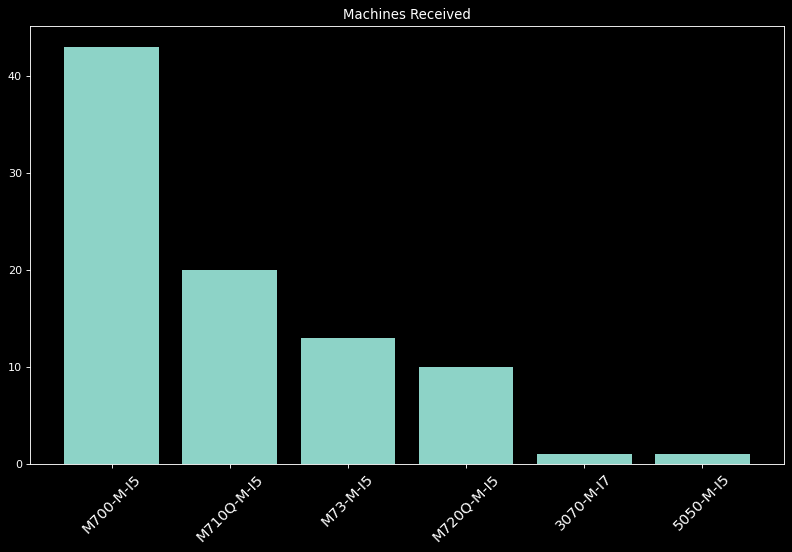

In [14]:
# visuals
plt.style.use('dark_background')
df_sorted = df.sort_values(by='COUNT', ascending=False)
plt.figure(figsize=(10,7), dpi=80)
plt.bar(df_sorted.MODELS, df_sorted.COUNT)
plt.xticks(rotation=45, fontsize=13)
plt.title('Machines Received')
plt.tight_layout()
plt.show()

The second visualization will be a pie chart representing a cost percentage of each of the total machines by type.

Arbitrarily I am "exploding" the second largest wedge of each graph. I am aware that this is typically done to add emphasis to the exploded wedge, but I was drawn to the challenge of making each pie chart look like pac-man. (Under reproducable conditions across separate source CSVs.)

The text on the interior of the pie chart is then changed to black for readability.

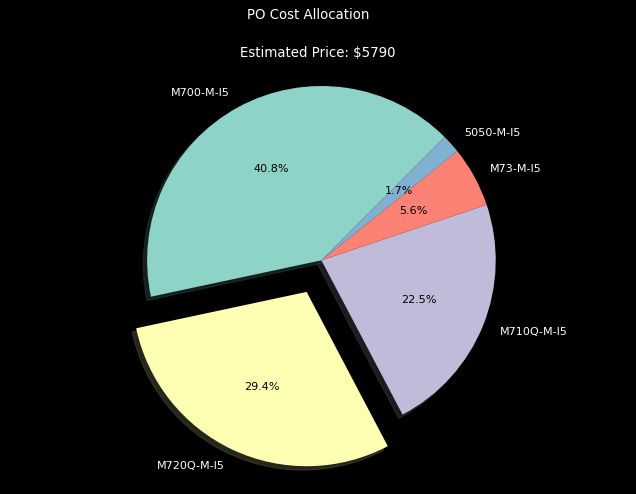

In [15]:
sorted_cost_vis = cost_vis.sort_values(by='TOTALPCT', ascending=False)
labels = sorted_cost_vis['MODELS']
sizes = sorted_cost_vis['TOTALPCT']

# Explode second largest wedge:
# A loop to create a tuple that serves as the (pie chart wedge) explode function data
# I realize an exploded wedge is meant to emphasize something,
# but I simply like how it looks like pac-man every time and I wanted to make this feature scalable across datasets
myexplode = ()
for i in sorted_cost_vis['TOTALPCT']:
    if len(myexplode) == 1:
        myexplode = myexplode + (0.2,)
    else:
        myexplode = myexplode + (0,)

fig1, ax1, = plt.subplots(figsize=(10,7), dpi=80)

# I don't really understand the _, but it's needed to change the autotext color
_, _, autotexts = ax1.pie(sizes, labels = labels, explode = myexplode, shadow=True, autopct='%1.1f%%', startangle=45)
# Make inner text more readable
for autotext in autotexts:
    autotext.set_color('black')

plt.suptitle('PO Cost Allocation')
plt.title('Estimated Price: $' + total_cost)
ax1.axis('equal')
plt.show()